In [7]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                                ])

In [8]:
trainset = datasets.MNIST('./dataset/MNIST/', download=True, train=True, transform=transform)
testset = datasets.MNIST('./dataset/MNIST/', download=True, train=False, transform=transform)

torch.Size([1, 28, 28])


In [16]:
class MyNeuralModel():
    def __init__(self, sizes, epochs=20, alpha=0.01):
        self.sizes = sizes
        self.epochs = epochs
        self.alpha = alpha
        self.init_params()

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def softmax(self, x):
        exes = np.exp(x)
        deno = np.sum(exes, axis=1)
        deno.resize(exes.shape[0], 1)
        return exes / deno

    def init_params(self, init='uniform'):
        input_layer = int(self.sizes[0])
        hidden_1 = int(self.sizes[1])
        hidden_2 = int(self.sizes[2])
        output_layer = int(self.sizes[3])
        if init=='uniform':
            self.w1 = np.random.uniform(low=-1, high=1, size=(input_layer, hidden_1))
            self.w2 = np.random.uniform(low=-1, high=1, size=(hidden_1, hidden_2))
            self.w3 = np.random.uniform(low=-1, high=1, size=(hidden_2, output_layer))
        if init=='zero':
            self.w1 = np.zeros((input_layer, hidden_1))
            self.w2 = np.zeros((hidden_1, hidden_2))
            self.w2 = np.zeros((hidden_2, output_layer))

    def forward(self, inputs):
        inputs = inputs.numpy()

        linear_1 = inputs.dot(self.w1)
        out1 = self.sigmoid(linear_1)

        linear_2 = out1.dot(self.w2)
        out2 = self.sigmoid(linear_2)

        linear3 = out2.dot(self.w3)
        out3 = self.softmax(linear3)
        return out3, out2, out1

    def backward(self, x_train, y_train, out3, out2, out1):
        x_train = x_train.numpy()
        y_train = y_train.numpy()

        batch_size = y_train.shape[0]

        d_loss = out3 - y_train
        delta_w3 = (1. / batch_size) * np.matmul(out2.T, d_loss)

        d_out_1 = np.matmul(d_loss, self.w3.T)
        d_linear_2 = d_out_1 * out2 * (1 - out2)
        delta_w2 = (1. / batch_size) * np.matmul(out1.T, d_linear_2)

        d_out_2 = np.matmul(d_linear_2, self.w2.T)
        d_linear_1 = d_out_2 * out1 * (1 - out1)
        delta_w1 = (1. / batch_size) * np.matmul(x_train.T, d_linear_1)
        
        return delta_w1, delta_w2 ,delta_w3

    def update_weights(self, w1_update, w2_update,w3_update):
        self.w1 -= self.alpha * w1_update
        self.w2 -= self.alpha * w2_update
        self.w3 -=self.alpha * w3_update

    def calculate_loss(self, y, y_hat):
        batch_size = y.shape[0]
        y = y.numpy()
        loss = np.sum(np.multiply(y, np.log(y_hat)))
        loss = -(1. / batch_size) * loss
        return loss

    def calculate_metrics(self, data_loader):
        losses = []
        correct = 0
        total = 0

        for i, data in enumerate(data_loader):
            x, y = data
            y_onehot = torch.zeros(y.shape[0], 10)
            y_onehot[range(y_onehot.shape[0]), y] = 1
            flattened_input = x.view(-1, 28 * 28)
            output, _, _ = self.forward(flattened_input)
            predicted = np.argmax(output, axis=1)
            correct += np.sum((predicted == y.numpy()))
            total += y.shape[0]
            loss = self.calculate_loss(y_onehot, output)
            losses.append(loss)
        return (correct / total), np.mean(np.array(losses))

    def train(self, train_loader, test_loader):
        self.losses = []
        self.accuracies = []
        for iteration in range(self.epochs):
            for i, data in enumerate(train_loader):
                x, y = data
                y_onehot = torch.zeros(y.shape[0], 10)
                y_onehot[range(y_onehot.shape[0]), y] = 1
                flat_input = x.view(-1, 28 * 28)
                out3, out2, out1 = self.forward(flat_input)
                w1_update, w2_update, w3_update = self.backward(flat_input, y_onehot, out3, out2, out1)
                self.update_weights(w1_update, w2_update,w3_update)
            accuracy, loss = self.calculate_metrics(test_loader)
            self.losses.append(loss)
            self.accuracies.append(accuracy)
            print('Epoch: {0}, Test Error Percent: {1:.2f}, Loss: {2:.2f}'.format(
                iteration + 1, 100 - accuracy * 100, loss
            ))

torch.Size([1, 28, 28])
Epoch: 1, Test Error Percent: 81.67, Loss: 3.01
Epoch: 2, Test Error Percent: 72.54, Loss: 2.44
Epoch: 3, Test Error Percent: 65.29, Loss: 2.08
Epoch: 4, Test Error Percent: 59.25, Loss: 1.83
Epoch: 5, Test Error Percent: 53.99, Loss: 1.64
Epoch: 6, Test Error Percent: 49.87, Loss: 1.50
Epoch: 7, Test Error Percent: 46.08, Loss: 1.39
Epoch: 8, Test Error Percent: 42.68, Loss: 1.29
Epoch: 9, Test Error Percent: 40.16, Loss: 1.22
Epoch: 10, Test Error Percent: 38.09, Loss: 1.15
Epoch: 11, Test Error Percent: 36.17, Loss: 1.10
Epoch: 12, Test Error Percent: 34.64, Loss: 1.05
Epoch: 13, Test Error Percent: 33.27, Loss: 1.01
Epoch: 14, Test Error Percent: 32.11, Loss: 0.97
Epoch: 15, Test Error Percent: 30.85, Loss: 0.94
Epoch: 16, Test Error Percent: 29.64, Loss: 0.91
Epoch: 17, Test Error Percent: 28.65, Loss: 0.89
Epoch: 18, Test Error Percent: 27.83, Loss: 0.86
Epoch: 19, Test Error Percent: 27.13, Loss: 0.84
Epoch: 20, Test Error Percent: 26.60, Loss: 0.82
Epoch

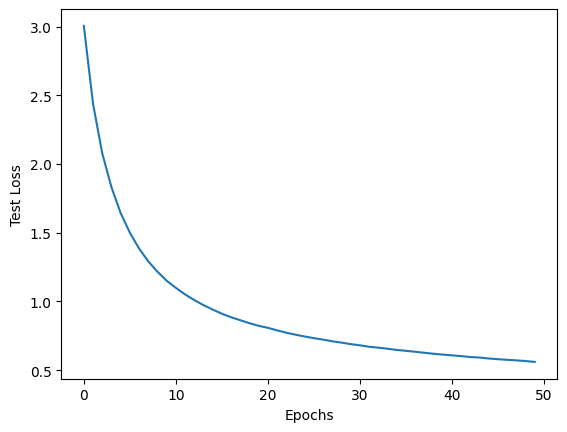

In [19]:
batchsize = 64
trainloader = DataLoader(trainset, batch_size=batchsize, shuffle=True)
dataloader = DataLoader(testset, batch_size=batchsize, shuffle=True)

examples = enumerate(testset)
batch_idx, (example_data, example_targets) = next(examples)
print(example_data.shape)

model = MyNeuralModel(sizes=[784, 300, 200, 10], epochs=50, alpha=0.001)
model.train(train_loader=trainloader, test_loader=dataloader)

plt.xlabel('Epochs')
plt.ylabel('Test Loss')
plt.plot(model.losses)
plt.show()